In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch, transformers
plt.style.use('ggplot')

import nltk
nltk.download('maxent_ne_chunker')
nltk.download('words')
#set seed for reproducibility
seed=42
#keras
import tensorflow as tf
from tensorflow import keras

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\paart\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\paart\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [6]:
# Read in data
df = pd.read_csv('Tweets.csv', encoding='ISO-8859-1')
df_tester = pd.read_csv('Tweets.csv')
df = df.drop(['textID', 'selected_text'], axis=1)
df_tester.drop(['textID', 'selected_text'], axis=1)
df = df.head(5000)
df_tester = df_tester.head(5000)

In [7]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [8]:
df.drop_duplicates(subset='text',inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4999 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


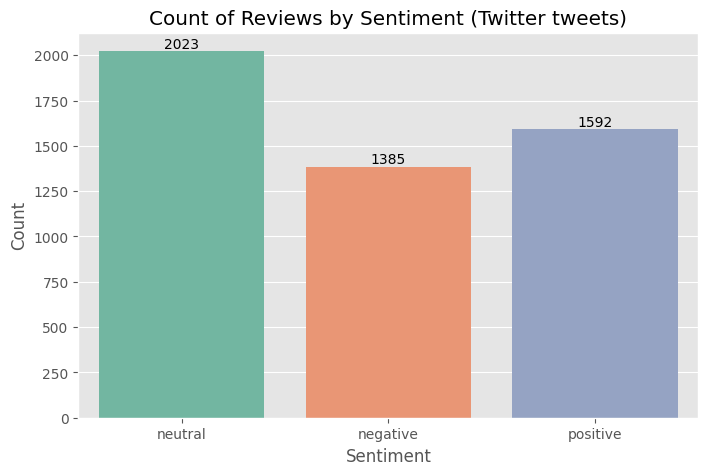

In [10]:
# Create a bar plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title('Count of Reviews by Sentiment (Twitter tweets)')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Annotate the bars with counts
for p in plt.gca().patches:
    plt.gca().annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

In [11]:
df = df[['text','sentiment']]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [12]:
df_tester = df_tester[['text','sentiment']]
df_tester.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [13]:
#data processing
import re, string
import emoji
import nltk

from tqdm.notebook import tqdm
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [14]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS
#Emojis will be left into the tweets as cardiffnlp is fine tuned

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [15]:
texts_new = []
for t in df.text:
    if pd.notna(t):  # Check if 't' is not NaN
        cleaned_text = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(str(t)))))
        texts_new.append(cleaned_text)
    else:
        texts_new.append("")  # Replace NaN with an empty string


In [16]:
texts_new_test = []
for t in df_tester.text:
    if pd.notna(t):  # Check if 't' is not NaN
        cleaned_text = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(str(t)))))
        texts_new_test.append(cleaned_text)
    else:
        texts_new_test.append("")  # Replace NaN with an empty string
    print("Processed:", t)

Processed:  I`d have responded, if I were going
Processed:  Sooo SAD I will miss you here in San Diego!!!
Processed: my boss is bullying me...
Processed:  what interview! leave me alone
Processed:  Sons of ****, why couldn`t they put them on the releases we already bought
Processed: http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
Processed: 2am feedings for the baby are fun when he is all smiles and coos
Processed: Soooo high
Processed:  Both of you
Processed:  Journey!? Wow... u just became cooler.  hehe... (is that possible!?)
Processed:  as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
Processed: I really really like the song Love Story by Taylor Swift
Processed: My Sharpie is running DANGERously low on ink
Processed: i want to go to music tonight but i lost my voice.
Processed: test test from the LG enV2
Processed: Uh oh, I am sunburned
Processed:  S`ok, trying to plot alternative

In [17]:
print("Length of texts_new:", len(texts_new))
print("Length of texts_new_test:", len(texts_new_test))
print("Number of rows in df:", len(df))
print("Number of rows in df_test:", len(df_tester))
print("Columns in df:", df.columns)
print("Columns in df_test:", df_tester.columns)

Length of texts_new: 5000
Length of texts_new_test: 5000
Number of rows in df: 5000
Number of rows in df_test: 5000
Columns in df: Index(['text', 'sentiment'], dtype='object')
Columns in df_test: Index(['text', 'sentiment'], dtype='object')


In [18]:
df['text_cleaned'] = texts_new
df_tester['text_cleaned'] = texts_new_test

In [19]:
df['text_cleaned'].head()

0                    id have responded if i were going
1           sooo sad i will miss you here in san diego
2                               my boss is bullying me
3                        what interview leave me alone
4    sons of why couldnt they put them on the relea...
Name: text_cleaned, dtype: object

In [20]:
df_tester['text_cleaned'].head()

0                    id have responded if i were going
1           sooo sad i will miss you here in san diego
2                               my boss is bullying me
3                        what interview leave me alone
4    sons of why couldnt they put them on the relea...
Name: text_cleaned, dtype: object

In [21]:
df['text_cleaned'][1:8].values

array(['sooo sad i will miss you here in san diego',
       'my boss is bullying me', 'what interview leave me alone',
       'sons of why couldnt they put them on the releases we already bought',
       'some shameless plugging for the best rangers forum on earth',
       '2am feedings for the baby are fun when he is all smiles and coos',
       'soooo high'], dtype=object)

In [22]:
text_len = []
for text in df.text_cleaned:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [23]:
df['text_len'] = text_len

In [24]:
text_len_test = []
for text in df_tester.text_cleaned:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [25]:
df_tester['text_len'] = text_len

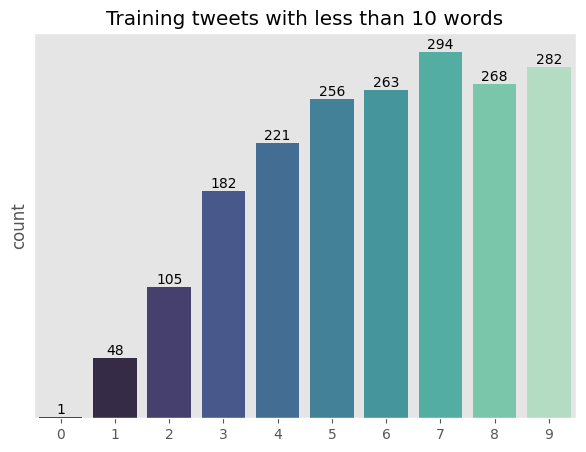

In [26]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

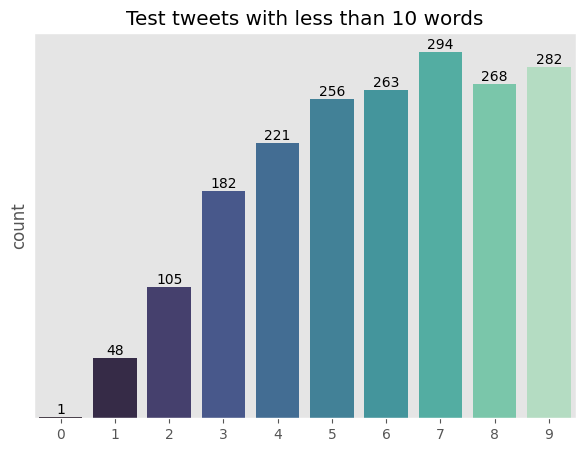

In [27]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_tester[df_tester['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [28]:
# Function to count words in a text
def count_words(text):
    words = text.split()
    return len(words)

# Apply the function to the 'Sentence' column and store the word counts in a new column
df['Word_Count'] = df['text_cleaned'].apply(count_words)

# Print sentences with less than 5 words
print("Sentences with less than 5 words:")
short_sentences = df[df['Word_Count'] < 5]['text_cleaned']
for sentence in short_sentences:
    print(sentence)

Sentences with less than 5 words:
soooo high
both of you
im sorry
mayday
romance zero is funny
will be back later
haha yes
is at a photoshoot
chilliin
my sources say no
i am sooo tired
thank yyyyyyyyyoooooooooouuuuu
has tickets
hahaa your awesomee
not well
not a prob hun
absolutely
whats the matter chickadee
why are you sad
hate fighting
me neither
my back hurtsreally bad
good morning
ok then
420 why baby
happy 1 year 3
i talk to you
more nightmares huggles
yellow for
feeling smooth like chrome
ew traffic
sounds like me
nesmith
thx
cool luv it
hope he is ok
hell yeah
i know
happy mothers day
thanks
twittering after 2 days
i am tres depressed
simple my a
ship im stuck

there
sucks
oh nice going
i agree with you
2nd aww thanks
aww you loooove me
awesome lucky you
19 days and counting
brainfreeze
my sunburn is peeling
i hate the dentist
qood morninq
needs more followers
have a good one
a mouth for sure
goodmorning
morning tweeple
still jealous
hicks are mean
thats another sponsor
thanks f

In [29]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_tester.shape}")

 DF SHAPE: (5000, 5)
 DF TEST SHAPE: (5000, 4)


In [30]:
df = df[df['text_len'] > 4]

In [31]:
df_tester = df_tester[df_tester['text_len'] > 4]

In [32]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_tester.shape}")
#prints the shape of the dataframe after duplicates are removed from the code 

 DF SHAPE: (4443, 5)
 DF TEST SHAPE: (4443, 4)


In [33]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import torch.nn as nn
#initializes the model for sentiment analysis and NLP
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
roberta_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
token_lens = []

for txt in df['text_cleaned'].values:
    tokens = tokenizer.encode(txt, max_length=5000, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [35]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 41


In [36]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 41


In [37]:
df['sentiment'].value_counts()

sentiment
neutral     1750
positive    1418
negative    1275
Name: count, dtype: int64

In [38]:
df['sentiment'] = df['sentiment'].map({'negative':-1,'positive':1,'neutral':0})

In [39]:
df_tester['sentiment'] = df_tester['sentiment'].map({'negative':-1,'positive':1,'neutral':0})

In [40]:
df['sentiment'].value_counts()

sentiment
 0    1750
 1    1418
-1    1275
Name: count, dtype: int64

In [41]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_cleaned']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_cleaned', 'sentiment']);

In [42]:
train_os['sentiment'].value_counts()

sentiment
 0    1750
-1    1750
 1    1750
Name: count, dtype: int64

In [43]:
X = train_os['text_cleaned'].values
y = train_os['sentiment'].values

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [45]:
X_tester = df_tester['text_cleaned'].values
y_tester = df_tester['sentiment'].values

In [46]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_tester.copy()

In [47]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_tester = ohe.fit_transform(np.array(y_tester).reshape(-1, 1)).toarray()

In [48]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_tester.shape[0]}" )

TRAINING DATA: 4725
VALIDATION DATA: 525
TESTING DATA: 4443


In [49]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

41

In [50]:
MAX_LEN=128

In [51]:
def tokenize_data(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    
    for text in data:
        # Use the tokenizer to tokenize the text
        inputs = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])
    
    return np.array(input_ids), np.array(attention_masks)

# Tokenize your data
train_input_ids, train_attention_masks = tokenize_data(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_data(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_data(X_tester, MAX_LEN)

In [52]:
def create_model(roberta_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Pass inputs through the RoBERTa model
    outputs = roberta_model(input_ids, attention_mask=attention_masks)

    # Access the logits
    logits = outputs.logits

    # Add classification layer
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(logits)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(opt, loss=loss, metrics=[accuracy])
    return model


In [53]:
print(output)


NameError: name 'output' is not defined

In [54]:
model = create_model(roberta_model, MAX_LEN)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246479   ['input_1[0][0]',             
 assification (TFRobertaFor  (loss=None, logits=(None,    39         'input_2[0][0]']             
 SequenceClassification)     3),                                                                  
                              hidden_states=None, atten                                       

In [55]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

Epoch 1/4
158/158 [==============================] - 1393s 9s/step - loss: 0.7283 - categorical_accuracy: 0.7266 - val_loss: 0.6337 - val_categorical_accuracy: 0.7524
Epoch 2/4
158/158 [==============================] - 1331s 8s/step - loss: 0.4991 - categorical_accuracy: 0.8171 - val_loss: 0.5795 - val_categorical_accuracy: 0.7848
Epoch 3/4
158/158 [==============================] - 1333s 8s/step - loss: 0.3966 - categorical_accuracy: 0.8671 - val_loss: 0.5743 - val_categorical_accuracy: 0.7924
Epoch 4/4
158/158 [==============================] - 1332s 8s/step - loss: 0.3150 - categorical_accuracy: 0.8967 - val_loss: 0.6501 - val_categorical_accuracy: 0.7905


In [56]:
model.save_weights('C:\SentimentAnal\RobertaWeightsTweetsSentiment.h5')

In [ ]:
#loaded_model =create_model(roberta_model, MAX_LEN)
#loaded_model.load_weights('C:\SentimentAnal\RobertaWeightsTweetsSentiment.h5')

In [57]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

139/139 [==============================] - 369s 3s/step


In [59]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

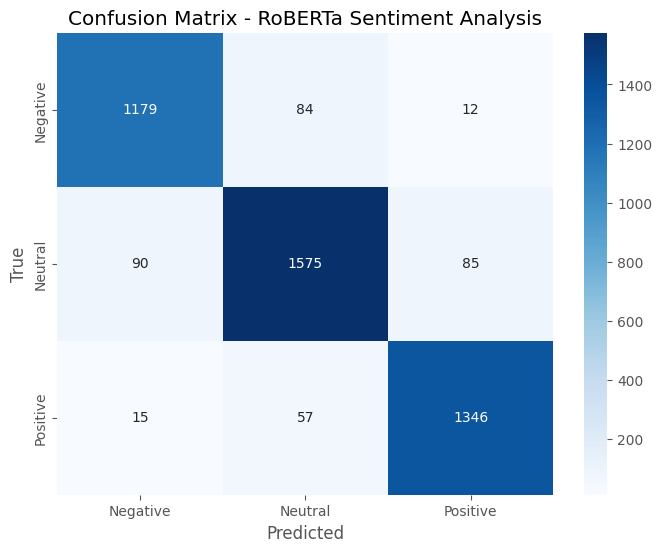

In [60]:
# Convert one-hot encoded predictions back to labels
y_pred_roberta_labels = np.argmax(y_pred_roberta, axis=1)
y_tester_labels = np.argmax(y_tester, axis=1)
# Calculate the confusion matrix
cm = confusion_matrix(y_tester_labels, y_pred_roberta_labels)

# Define class labels
class_labels = ['Negative', 'Neutral', 'Positive']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RoBERTa Sentiment Analysis')
plt.show()

In [57]:
# Assuming you have already defined result_roberta and X_tester
# Find the indices of the most positive, negative, and neutral tweets
most_positive_idx = np.argmax(result_roberta, axis=0)
most_negative_idx = np.argmin(result_roberta, axis=0)
neutral_idx = np.argmin(np.abs(result_roberta - 0.5), axis=0)  # Find the closest to neutral (0.5) sentiment

# Print the most positive tweet and sentiment scores
print("Most Positive Tweet:")
print("Sentiment Score:", result_roberta[most_positive_idx][0])
print("Text:", X_tester[most_positive_idx][0])

# Print the most negative tweet and sentiment scores
print("\nMost Negative Tweet:")
print("Sentiment Score:", result_roberta[most_negative_idx][0])
print("Text:", X_tester[most_negative_idx][0])

# Print the most neutral tweet and sentiment scores
print("\nMost Neutral Tweet:")
print("Sentiment Score:", result_roberta[neutral_idx][0])
print("Text:", X_tester[neutral_idx][0])


Most Positive Tweet:
Sentiment Score: [0.9923481  0.00538217 0.00226982]
Text: i have no idea what im doing and i am completely lost

Most Negative Tweet:
Sentiment Score: [4.6001596e-04 7.9062125e-03 9.9163377e-01]
Text: hi my name is chelsea and i respect your opinion when it comes to dwts you were great on there too

Most Neutral Tweet:
Sentiment Score: [0.49993497 0.4961105  0.00395445]
Text: watching the movie 1984 for my book report im lazy to read


In [ ]:
print(result_roberta[:2])


In [1]:
most_negative_index = np.argmax(result_roberta[:, 0])  # Index with the highest negative sentiment score
most_negative_text = tokenizer.decode(test_input_ids[most_negative_index], skip_special_tokens=True)
most_negative_scores = result_roberta[most_negative_index]
print("Most Negative Text:")
print("Text:", most_negative_text)
print("Sentiment Scores:", most_negative_scores)


NameError: name 'np' is not defined

In [ ]:
most_positive_index = np.argmax(result_roberta[:, 2])  # Index with the highest positive sentiment score
most_positive_text = tokenizer.decode(test_input_ids[most_positive_index], skip_special_tokens=True)
most_positive_scores = result_roberta[most_positive_index]
print("Most Positive Text:")
print("Text:", most_positive_text)
print("Sentiment Scores:", most_positive_scores)


In [59]:
most_neutral_index = np.argmax(result_roberta[:, 1])  # Index with the highest positive sentiment score
most_neutral_text = tokenizer.decode(test_input_ids[most_neutral_index], skip_special_tokens=True)
most_neutral_scores = result_roberta[most_neutral_index]
print("Most Neutral Text:")
print("Text:", most_neutral_text)
print("Sentiment Scores:", most_neutral_scores)


Most Neutral Text:
Text: just finished watching marley and me
Sentiment Scores: [0.00763986 0.9869055  0.00545466]


In [ ]:
# Define probability thresholds for classification
positive_threshold = 0.6  # Example threshold
neutral_threshold = 0.2  # Example threshold
negative_threshold = 0.2  # Example threshold

# Initialize variables to store the most extreme sentiments
most_positive_sentiment = {"text": None, "sentiment": "Negative", "score": 0}
most_negative_sentiment = {"text": None, "sentiment": "Positive", "score": 0}
most_neutral_sentiment = {"text": None, "sentiment": "Neutral", "score": 0}

# Loop through the RoBERTa sentiment scores
for i, sentiment_scores in enumerate(result_roberta):
    positive_score, neutral_score, negative_score = sentiment_scores

    # Classify the sentiment based on the highest probability
    if positive_score > neutral_score and positive_score > negative_score:
        sentiment = "Positive"
    elif negative_score > positive_score and negative_score > neutral_score:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    # Record the most extreme sentiments
    if positive_score > most_positive_sentiment["score"]:
        most_positive_sentiment = {"text": texts_new[i], "sentiment": "Positive", "score": positive_score}
    elif negative_score > most_negative_sentiment["score"]:
        most_negative_sentiment = {"text": texts_new[i], "sentiment": "Negative", "score": negative_score}
    elif neutral_score > most_neutral_sentiment["score"]:
        most_neutral_sentiment = {"text": texts_new[i], "sentiment": "Neutral", "score": neutral_score}

# Print the most extreme sentiments
print("Most Positive Text:", most_positive_sentiment["text"])
print("Sentiment:", most_positive_sentiment["sentiment"])
print("Score:", most_positive_sentiment["score"])
print()
print("Most Negative Text:", most_negative_sentiment["text"])
print("Sentiment:", most_negative_sentiment["sentiment"])
print("Score:", most_negative_sentiment["score"])
print()
print("Most Neutral Text:", most_neutral_sentiment["text"])
print("Sentiment:", most_neutral_sentiment["sentiment"])
print("Score:", most_neutral_sentiment["score"])


In [ ]:


# Find the indices of the most positive, negative, and neutral tweets
most_positive_indices = np.argmax(result_roberta[:, 2], axis=0)  # Index for positive sentiment scores
most_negative_indices = np.argmin(result_roberta[:, 0], axis=0)  # Index for negative sentiment scores
neutral_indices = np.argmin(np.abs(result_roberta[:, 1] - 0.5), axis=0)  # Index for the sentiment scores closest to neutral

# Decode the tokenized tweets back to text
most_positive_tweet = tokenizer.decode(test_input_ids[most_positive_indices])
most_negative_tweet = tokenizer.decode(test_input_ids[most_negative_indices])
neutral_tweet = tokenizer.decode(test_input_ids[neutral_indices])

# Access the sentiment scores for the most positive, negative, and neutral tweets
positive_sentiment_scores = result_roberta[most_positive_indices][2]
negative_sentiment_scores = result_roberta[most_negative_indices][0]
neutral_sentiment_scores = result_roberta[neutral_indices][1]

# Print the most positive tweet and sentiment scores
print("Most Positive Tweet:")
print("Negative Sentiment Score:", negative_sentiment_scores)
print("Neutral Sentiment Score:", neutral_sentiment_scores)
print("Positive Sentiment Score:", positive_sentiment_scores)
print("Text:", most_positive_tweet)

# Print the most negative tweet and sentiment scores
print("\nMost Negative Tweet:")
print("Negative Sentiment Score:", negative_sentiment_scores)
print("Neutral Sentiment Score:", neutral_sentiment_scores)
print("Positive Sentiment Score:", positive_sentiment_scores)
print("Text:", most_negative_tweet)

# Print the most neutral tweet and sentiment scores
print("\nMost Neutral Tweet:")
print("Negative Sentiment Score:", negative_sentiment_scores)
print("Neutral Sentiment Score:", neutral_sentiment_scores)
print("Positive Sentiment Score:", positive_sentiment_scores)
print("Text:", neutral_tweet)


In [ ]:
# Find the indices of the most positive, negative, and neutral tweets
most_positive_idx = np.argmax(result_roberta[:, 2], axis=0)  # Index for positive sentiment score
most_negative_idx = np.argmin(result_roberta[:, 0], axis=0)  # Index for negative sentiment score
neutral_idx = np.argmin(np.abs(result_roberta[:, 1] - 0.5), axis=0)  # Index for the sentiment score closest to neutral

# Decode the tokenized tweets back to text
most_positive_tweet = tokenizer.decode(test_input_ids[most_positive_idx])
most_negative_tweet = tokenizer.decode(test_input_ids[most_negative_idx])
neutral_tweet = tokenizer.decode(test_input_ids[neutral_idx])

# Access the sentiment scores for the most positive, negative, and neutral tweets
positive_sentiment_scores = result_roberta[most_positive_idx][2]
negative_sentiment_scores = result_roberta[most_negative_idx][0]
neutral_sentiment_scores = result_roberta[neutral_idx][1]

# Print the most positive tweet and sentiment scores
print("Most Positive Tweet:")
print("Negative Sentiment Score:", negative_sentiment_scores)
print("Neutral Sentiment Score:", neutral_sentiment_scores)
print("Positive Sentiment Score:", positive_sentiment_scores)
print("Text:", most_positive_tweet)

# Print the most negative tweet and sentiment scores
print("\nMost Negative Tweet:")
print("Negative Sentiment Score:", negative_sentiment_scores)
print("Neutral Sentiment Score:", neutral_sentiment_scores)
print("Positive Sentiment Score:", positive_sentiment_scores)
print("Text:", most_negative_tweet)

# Print the most neutral tweet and sentiment scores
print("\nMost Neutral Tweet:")
print("Negative Sentiment Score:", negative_sentiment_scores)
print("Neutral Sentiment Score:", neutral_sentiment_scores)
print("Positive Sentiment Score:", positive_sentiment_scores)
print("Text:", neutral_tweet)

In [ ]:
#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_tester,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
example = df_tester['text'][176]
print(example)

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df_tester.iterrows(), total=len(df_tester)):
    try:
        text = row['text']
        roberta_result = polarity_scores_roberta(text)
        res[i] = roberta_result
    except RuntimeError:
        print(f'Broke for row index {i}')

In [ ]:
results_df_tester = pd.DataFrame(res).T
# Add a new column 'Id' to both DataFrames using the row index
df_tester['Id'] = df_tester.index
results_df_tester['Id'] = results_df_tester.index

# Merge the DataFrames based on the 'Id' column
merged_df_tester = df_tester.merge(results_df_tester, on='Id', how='left')

In [ ]:
results_df_tester.columns

In [ ]:
print(merged_df_tester)
merged_df_tester.head()

In [ ]:
# Create a function to map the highest sentiment score to -1, 0, or 1
def map_sentiment(row):
    sentiment_scores = [row['roberta_neg'], row['roberta_neu'], row['roberta_pos']]
    max_score = max(sentiment_scores)
    if max_score == row['roberta_neg']:
        return -1
    elif max_score == row['roberta_neu']:
        return 0
    else:
        return 1

# Apply the mapping function to create a new column 'mapped_sentiment'
merged_df_tester['mapped_sentiment'] = merged_df_tester.apply(map_sentiment, axis=1)

# Assuming you have the ground truth labels in a 'sentiment' column
actual_labels = merged_df_tester['sentiment'].values
predicted_labels = merged_df_tester['mapped_sentiment'].values



In [ ]:
from sklearn.metrics import classification_report

# Assuming you have actual labels in a 'sentiment' column and mapped labels in 'mapped_sentiment' column
actual_labels = merged_df_tester['sentiment'].values
predicted_labels = merged_df_tester['mapped_sentiment'].values

# Create a label mapping for display in the classification report
label_mapping = {-1: 'negative', 0: 'neutral', 1: 'positive'}

# Map the labels back to their original strings for display
actual_labels_str = [label_mapping[label] for label in actual_labels]
predicted_labels_str = [label_mapping[label] for label in predicted_labels]

# Generate the classification report
classification_rep = classification_report(actual_labels_str, predicted_labels_str)

print(classification_rep)


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have actual labels in a 'sentiment' column and mapped labels in 'mapped_sentiment' column
actual_labels = merged_df['sentiment'].values
predicted_labels = merged_df['mapped_sentiment'].values

# Create a label mapping for display
label_mapping = {-1: 'negative', 0: 'neutral', 1: 'positive'}

# Map the labels back to their original strings for display
predicted_labels_str = [label_mapping[label] for label in predicted_labels]

# Count the occurrences of each sentiment
sentiment_counts = {label: predicted_labels_str.count(label) for label in label_mapping.values()}

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.keys(), sentiment_counts.values())
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Predicted Sentiments by Roberta')

# Add count labels on top of each bar
for bar, count in zip(bars, sentiment_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom')

plt.show()


In [1]:
from sklearn.metrics import confusion_matrix
# Assuming you have actual labels in a 'sentiment' column and mapped labels in 'mapped_sentiment' column
actual_labels = merged_df['sentiment'].values
predicted_labels = merged_df['mapped_sentiment'].values

# Create a label mapping for display
label_mapping = {-1: 'negative', 0: 'neutral', 1: 'positive'}

# Create confusion matrices for each sentiment class
confusion_matrices = {}
for sentiment_label, sentiment_name in label_mapping.items():
    # Filter actual and predicted labels for the specific sentiment class
    actual_sentiment = [1 if label == sentiment_label else 0 for label in actual_labels]
    predicted_sentiment = [1 if label == sentiment_label else 0 for label in predicted_labels]
    
    # Calculate the confusion matrix
    confusion = confusion_matrix(actual_sentiment, predicted_sentiment)
    confusion_matrices[sentiment_name] = confusion

# Plot the confusion matrices
for sentiment_name, confusion_matrix in confusion_matrices.items():
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not ' + sentiment_name, sentiment_name],
                yticklabels=['Not ' + sentiment_name, sentiment_name])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {sentiment_name} Sentiment')
    plt.show()



NameError: name 'merged_df' is not defined

In [ ]:
'''
# a function that takes text and model to calculate probability of each sentiment
def sentiment_analyzer(text, model):
    encoded_input = tokenizer(text, return_tensors="pt")
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = np.round(softmax(scores), 2)
    scores_dict = {"roberta_neg": scores[0], "roberta_neu": scores[1], "roberta_pos": scores[2]}
    return scores_dict\
'''

In [ ]:
'''
# apply the roberta function
df["probabilities"] = df['text'].apply(sentiment_analyzer, model=model)

# since roberta model returned probability of each sentiment as a dictionary
# let's convert each probaility into separate column
probabilities = df["probabilities"].apply(pd.Series)
df = df.join(probabilities)
df = df.drop("probabilities", axis=1)
'''

In [ ]:
'''
# Label assignment is not being completed accurately, need to reassign values
# now calculate the polarity for each text by:
# first multiplying each probability to its weights (-1=> negative, 0=>neutral and +1=>positive)
# then sum the values and pass through Tanh function to scale values from -1 up to +1
# finally we can assign labels for each text, depending on the polarity, e.g. -1.0 until -0.25 negavite
polarity_weights = torch.tensor([-1, 0, 1])
probs = torch.tensor(df[["neg", "neu", "pos"]].values)
polarity = polarity_weights * probs
polarity = polarity.sum(dim=-1)
polarity_scaled = nn.Tanh()(polarity)
df_tester["roberta_polarity"] = polarity_scaled.numpy()
df_tester["roberta_sentiment"] = pd.cut(df_tester["roberta_polarity"],
    bins=[-1.0, -0.25, 0.25, 1.0],labels=["Negative", "Neutral", "Positive"],)
df_tester = df_tester.drop(["neg", "neu", "pos"], axis=1)
df_tester.head() 
'''

In [ ]:
#tokenizerRoberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [ ]:
'''
token_lens = []

for txt in X_train:
    tokens = tokenizerRoberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length
'''

In [ ]:
#MAX_LEN=128

In [ ]:
'''
def tokenizerRoberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizerRoberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)
'''

In [ ]:
#test_input_ids, test_attention_masks = tokenizerRoberta(X_tester, MAX_LEN)